## Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---


In [6]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        img = mpimg.imread(file)
        file_features = single_img_features(img, color_space, spatial_size, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
        features.append(file_features)
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    # Iterate through the list of images
    file_features = []

    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
        file_features.append(hog_features)
    # Return list of feature vectors  
    return np.concatenate(file_features)

    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


In [7]:
import glob

cars = glob.glob('vehicles/**/*.png')
notcars = glob.glob('non-vehicles/**/*.png')
print('Images of vehicles:', len(cars))
print('Images of non vehicles:', len(notcars))

Images of vehicles: 8792
Images of non vehicles: 8968


In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import pickle
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins=32 # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
car_features = extract_features(cars, color_space, spatial_size,hist_bins, orient,pix_per_cell,
                         cell_per_block, hog_channel,spatial_feat, hist_feat, hog_feat)
notcar_features = extract_features(notcars, color_space, spatial_size,hist_bins, orient,pix_per_cell,
                         cell_per_block, hog_channel,spatial_feat, hist_feat, hog_feat)

print(len(car_features))



t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)    

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print('scaled_X shape:', scaled_X.shape)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('Feature vector shape:', X_train.shape)
print('Feature vector shape:', X_test.shape)

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()

print('My SVC predicts: ', svc.predict(X_test))
print('For these', 'labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict','labels with SVC')

# Save results for later use
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
pickle.dump( dist_pickle, open( "svc_pickle.p", "wb" ) )

/Users/jiforcen/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


500
4.68 Seconds to extract HOG features...
scaled_X shape: (1000, 8460)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
Feature vector shape: (800, 8460)
Feature vector shape: (200, 8460)
0.41 Seconds to train SVC...
Test Accuracy of SVC =  0.995
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.  1.  1.  1.  0.  1.
  0.  0.  0.  1.  0.  0.  0.  1.  1.  1.  1.  0.  1.  0.  1.  0.  1.  1.
  1.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  1.
  0.  0.  1.  0.  0.  1.  1.  1.  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  1.  1.  1.  0.  1.  0.  1.  0.  1.  1.  0.  0.
  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  0.  1.  0.  1.  0.  0.  0.  1.
  1.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.
  0.  1.  1.  0.  0.  0.  1.  1.  1

In [9]:
image = mpimg.imread(cars[0])
print(image.min())
print(image.max())
print(image.dtype)


0.129412
0.752941
float32


In [10]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    
        #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space, spatial_size, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1)).astype(np.float64)         
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

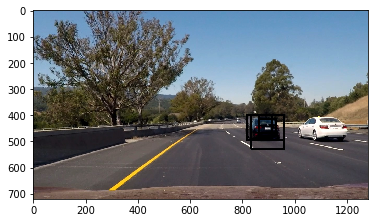

In [11]:
import matplotlib.image as mpimg
import os

file_path = os.getcwd()
file_path = file_path + '/test_images/test6.jpg'
image = mpimg.imread(file_path).astype(np.float32) /255.0
draw_image = np.copy(image)

y_start_stop = [350, 500] # Min and max in y to search in slide_window()
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

y_start_stop = [400, 600] # Min and max in y to search in slide_window()
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
hot_windows = hot_windows + search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
                             
y_start_stop = [400, 720] # Min and max in y to search in slide_window()
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
hot_windows = hot_windows + search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

y_start_stop = [400, 720] # Min and max in y to search in slide_window()
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(196, 196), xy_overlap=(0.5, 0.5))
hot_windows = hot_windows + search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

y_start_stop = [400, 720] # Min and max in y to search in slide_window()
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(260, 260), xy_overlap=(0.5, 0.5))
hot_windows = hot_windows + search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  

plt.imshow(window_img)
plt.show()

In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #img = img.astype(np.float32)/255
    draw_img = np.copy(img)
    boxes = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    #ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    #print(nblocks_per_window)
    #nblocks_per_window = 5
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch

            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            #hog_features = []
            #for channel in range(feature_image.shape[2]):
            #    hog_features.append(get_hog_features(feature_image[:,:,channel], 
            #                        orient, pix_per_cell, cell_per_block, 
            #                        vis=False, feature_vec=True))
            #hog_features = np.ravel(hog_features)  
            

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

            #print(len(spatial_features))
            #print(len(hist_features))
            #print(len(hog_features))

            act_features = []
            #if spatial_feat == True:
            act_features.append(spatial_features)
            #if hist_feat == True:
            act_features.append(hist_features)
            #if hog_feat == True:
            act_features.append(hog_features)
                     
            test_features = X_scaler.transform(np.array(np.concatenate(act_features)).reshape(1, -1)).astype(np.float64)  
            #test_features = X_scaler.transform(np.array(act_features).reshape(1, -1)).astype(np.float64)         

            
            test_prediction = svc.predict(test_features)
            
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return boxes


In [13]:
def find(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    ystart = 350
    ystop = 656
    scale = 1.0
    boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    ystart = 400
    ystop = 720
    scale = 1.0
    boxes = boxes + find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    start = 400
    ystop = 720
    scale = 1.5
    boxes = boxes + find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    start = 400
    ystop = 720
    scale = 2.0
    boxes = boxes + find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    start = 400
    ystop = 720
    scale = 2.5
    boxes = boxes + find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    start = 400
    ystop = 720
    scale = 3.0
    boxes = boxes + find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    start = 400
    ystop = 720
    scale = 3.5
    boxes = boxes + find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    start = 400
    ystop = 720
    scale = 4.0
    boxes = boxes + find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    return boxes


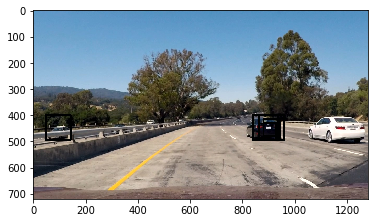

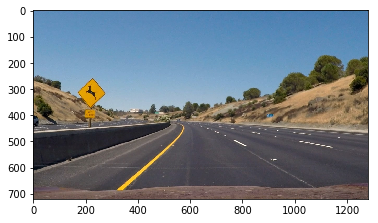

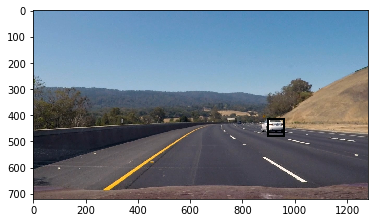

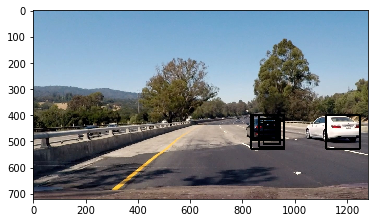

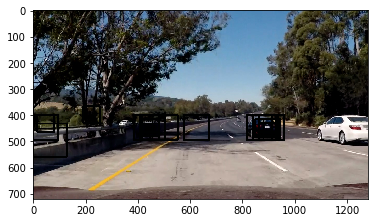

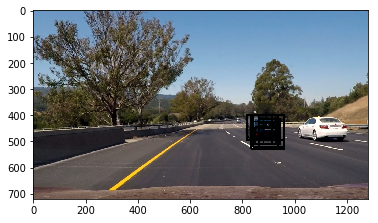

In [14]:
import matplotlib.image as mpimg
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import glob

# Make a list of test images
file_path = os.getcwd()
file_path = file_path + '/test_images/test*.jpg'
images = glob.glob(file_path) 
dist_pickle = pickle.load( open( "svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]

for fname in images:    
    img = mpimg.imread(fname).astype(np.float32) /255.0
    boxes = find(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    out_img = draw_boxes(img, boxes, (0, 255, 255), thick=6)

    plt.imshow(out_img)
    plt.show()

In [16]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [17]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [18]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [77]:
# Process pipeline
def detection_pipeline(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    boxes = find(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    out_img = draw_boxes(img, boxes, (0, 255, 255), thick=6)

    # Read in a pickle file with bboxes saved
    # Each item in the "all_bboxes" list will contain a 
    # list of boxes for one of the images shown above
    box_list = boxes

    # Read in image similar to one shown above 
    image = out_img
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return out_img,draw_img,heatmap

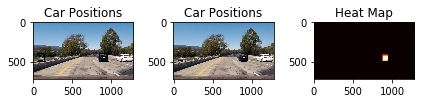

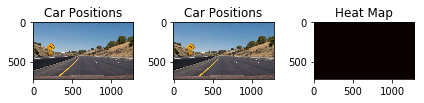

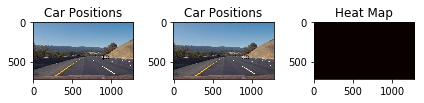

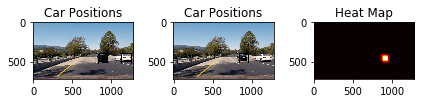

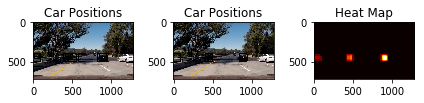

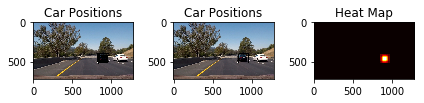

In [78]:
import matplotlib.image as mpimg
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import glob

# Make a list of test images
file_path = os.getcwd()
file_path = file_path + '/test_images/test*.jpg'
images = glob.glob(file_path) 
dist_pickle = pickle.load( open( "svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]

for fname in images:    
    img = mpimg.imread(fname).astype(np.float32) /255.0
    
    out_img,draw_img,heatmap = detection_pipeline(img, svc, X_scaler, 
                                    orient, pix_per_cell, cell_per_block, 
                                    spatial_size, hist_bins)

    fig = plt.figure()
    figsize=(15, 15)
    plt.subplot(131)
    plt.imshow(out_img)
    plt.title('Car Positions')
    plt.subplot(132)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(133)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()

In [79]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [80]:
# Process pipeline with aditional information
def process_image_ex(img):
    img = img.astype(np.float32) /255.0

    out_img,draw_img,heatmap = detection_pipeline(img, svc, X_scaler, 
                                orient, pix_per_cell, cell_per_block, 
                                spatial_size, hist_bins)
    
    output1 = cv2.resize(out_img,(640, 360), interpolation = cv2.INTER_AREA)
    output2 = cv2.resize(heatmap,(640, 360), interpolation = cv2.INTER_AREA)
    output2 = np.dstack((output2, output2, output2))

    # Create an array big enough to hold both images next to each other.
    vis = np.zeros((720, 1280+640, 3))

    # Copy both images into the composed image.
    vis[:720, :1280,:] = draw_img*255
    vis[:360, 1280:1920,:] = output1*255
    vis[360:720, 1280:1920,:] = output2*255/np.amax(heatmap)
    
    return vis

In [81]:
print(np.amax(heatmap))

20.0


In [ ]:
file_path = os.getcwd()
file_path = file_path + '/test_images/test*.jpg'
images = glob.glob(file_path) 
dist_pickle = pickle.load( open( "svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]

video_output = 'test_video_vis.mp4'

clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image_ex)#.subclip(0,0.2) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_vis.mp4
[MoviePy] Writing video test_video_vis.mp4



  8%|▊         | 3/39 [00:09<01:58,  3.30s/it]

In [72]:
HTML("""
<video width="800" height="300" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Apply a distortion correction to raw images.


In [ ]:
def undistort_image(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [ ]:
import pickle
%matplotlib inline

# Test undistortion on an image
file_path = os.getcwd()
file_path = file_path + '/camera_cal/calibration1.jpg'
img = cv2.imread(file_path)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

file_path = os.getcwd()
file_path = file_path + '/output_images/calibration1_undist.jpg'
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite(file_path,dst)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_results.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
import matplotlib.image as mpimg
# Test undistortion on an image
file_path = os.getcwd()
file_path = file_path + '/test_images/test1.jpg'
img = mpimg.imread(file_path)
img_size = (img.shape[1], img.shape[0])

dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

#### Use color transforms, gradients, etc., to create a thresholded binary image.

In [ ]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Take the gradient in x and y separately in l_channel
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1)
    
    # Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2+sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # Create a binary mask where mag thresholds are met
    binary_output_l = np.zeros_like(scaled_sobel)
    binary_output_l[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    # Take the gradient in x and y separately in s_channel
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1)
    
    # Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2+sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # Create a binary mask where mag thresholds are met
    binary_output_s = np.zeros_like(scaled_sobel)
    binary_output_s[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1    
    
    binary_output = cv2.bitwise_or(binary_output_l,binary_output_s)
    
    return binary_output

In [ ]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    l_channel = cv2.equalizeHist(l_channel)
    s_channel = cv2.equalizeHist(s_channel)
    
    # Take the derivative in x or y given orient = 'x' or 'y' in l_channel
    if orient == 'x':
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobelx)
    else:
        sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely)
        
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    binary_output_l = np.zeros_like(scaled_sobel)
    binary_output_l[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Take the derivative in x or y given orient = 'x' or 'y' in s_channel
    if orient == 'x':
        sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobelx)
    else:
        sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely)
        
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    binary_output_s = np.zeros_like(scaled_sobel)
    binary_output_s[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    binary_output = cv2.bitwise_or(binary_output_l,binary_output_s)
    
    return binary_output

In [ ]:
def S_threshold(img, s_thresh):

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    #s_channel = cv2.equalizeHist(s_channel)

    # Define range of yellow color in HLS 
    lower = np.array([15,100,100])
    upper = np.array([35,255,255])
    
    # Threshold the HLS image to get only blue colors
    s_binary_y = cv2.inRange(hls, lower, upper)
    
    # Define range of white color in HLS 
    lower = np.array([0,200,0])
    upper = np.array([255,255,255])
    
    # Threshold the HSV image to get only blue colors
    s_binary_w = cv2.inRange(hls, lower, upper)
    
    s_binary = cv2.bitwise_or(s_binary_y,s_binary_w)

    return s_binary

In [ ]:
def dir_threshold(img, sobel_kernel=3, abs_thres=(20), dir_thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    #l_channel = cv2.equalizeHist(l_channel)
    #s_channel = cv2.equalizeHist(s_channel)

    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the x and y gradients
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    
    abs_sobel = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobel/np.max(abs_sobel))
    abs_sobel = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobel/np.max(abs_sobel))

    sobelx[(scaled_sobelx<abs_thres)] = 0
    sobely[(scaled_sobely<abs_thres)] = 0

    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(sobely,sobelx)

    # Create a binary mask where direction thresholds are met
    binary_output_l = np.zeros_like(absgraddir)
    binary_output_l[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the x and y gradients
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    
    abs_sobel = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobel/np.max(abs_sobel))
    abs_sobel = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobel/np.max(abs_sobel))

    sobelx[(scaled_sobelx<abs_thres)] = 0
    sobely[(scaled_sobely<abs_thres)] = 0

    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(sobely,sobelx)
    
    # Create a binary mask where direction thresholds are met
    binary_output_s = np.zeros_like(absgraddir)
    binary_output_s[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    
    binary_output = cv2.bitwise_or(binary_output_l,binary_output_s)
    
    return binary_output

In [ ]:
def R_threshold(img, r_thresh):
    R = img[:,:,0]
    
    r_binary = np.zeros_like(R)
    r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1
    
    return r_binary

In [ ]:
# Threshold pipeline.
def image_threshold(img):
    
    mag_binary = np.uint8(mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))) #65
    #mag_binary = cv2.erode(mag_binary, np.ones((3, 3)))

    #sobelx_binary = np.uint8(abs_sobel_thresh(img, orient='x', thresh_min=35, thresh_max=255))
    #sobelx_binary = cv2.erode(sobelx_binary, np.ones((31, 31)))

    #sobely_binary = np.uint8(abs_sobel_thresh(img, orient='y', thresh_min=30, thresh_max=255))
    dir_binary = np.uint8(dir_threshold(img, sobel_kernel=15, abs_thres=(20), dir_thresh=(np.pi/2-1,np.pi/2-0.2)))
    #dir_binary = cv2.erode(dir_binary, np.ones((3, 3)))

    s_binary = np.uint8(S_threshold(img, s_thresh=(150, 255)))
    r_binary = np.uint8(R_threshold(img, r_thresh=(220, 255)))
    
    ch1_binary = cv2.bitwise_or(s_binary,r_binary)
    ch2_binary = mag_binary#cv2.bitwise_or(sobelx_binary,mag_binary)
    ch3_binary = (dir_binary)
    binary_stack = 255*np.dstack((ch1_binary, ch2_binary, ch3_binary))

    binary = np.zeros_like(s_binary)
    binary[(ch1_binary > 0) | (ch2_binary > 0) |(ch3_binary > 0)] = 255
    binary = cv2.erode(binary, np.ones((3, 3)))

    return binary,binary_stack

In [ ]:
import matplotlib.image as mpimg
# Make a list of test images
file_path = os.getcwd()
file_path = file_path + '/test_images/test*.jpg'
images = glob.glob(file_path) 

i=0
for fname in images:    
    image = mpimg.imread(fname)
    res,result = image_threshold(image)
    
    i=i+1
    file_path = os.getcwd()
    file_path = file_path + '/output_images/' + 'binary' + str(i) + '.jpg'
    cv2.imwrite(file_path,res)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=25)

    ax2.imshow(res)
    ax2.set_title('Pipeline Result', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()


## Apply a perspective transform to rectify binary image ("birds-eye view").

In [ ]:
def image_unwarp(img):
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    
    # 4 destination points dst = np.float32([[,],[,],[,],[,]])
    src = np.float32([[590,450],[700,450],[1133,680],[200,680]])
    offset = 200 # offset for dst points
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                      [img_size[0]-offset, img_size[1]], 
                      [offset, img_size[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

    return warped,Minv


In [ ]:
import matplotlib.image as mpimg
# Make a list of test images
file_path = os.getcwd()
file_path = file_path + '/output_images/binary*.jpg'
images = glob.glob(file_path) 

i=0
for fname in images:    
    image = mpimg.imread(fname)

    top_down,M = image_unwarp(image)

    i=i+1
    file_path = os.getcwd()
    file_path = file_path + '/output_images/' + 'warp' + str(i) + '.jpg'
    cv2.imwrite(file_path,top_down)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    image = np.array(cv2.merge((image,image,image)),np.uint8)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=25)
    
    top_down = np.array(cv2.merge((top_down,top_down,top_down)),np.uint8)
    ax2.imshow(top_down)
    ax2.set_title('Pipeline Result', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary.

In [ ]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

In [ ]:
def find_window_centroids(warped, window_width, window_height, margin):
    
    window_left_centroids = [] # Store the (left,right) window centroid positions per level
    window_right_centroids = [] # Store the (left,right) window centroid positions per level

    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_left_centroids.append(l_center)
    window_right_centroids.append(r_center)

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        if (max(conv_signal[l_min_index:l_max_index])>1000):
            window_left_centroids.append(l_center)
 
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        if (max(conv_signal[r_min_index:r_max_index])>1000):
            window_right_centroids.append(r_center)
        # Add what we found for that layer
    return window_left_centroids,window_right_centroids

In [ ]:
def detect_lanes(binary_warped,n_filter):
    # Global variables
    global global_left_fitx
    global global_right_fitx
    global global_left_fit_cr
    global global_right_fit_cr

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Append Global variables
    global_left_fitx.append(left_fit)
    global_left_fitx = global_left_fitx[-n_filter:]
    left_fit = np.median(np.array(global_left_fitx), axis=0)

    global_right_fitx.append(right_fit)
    global_right_fitx = global_right_fitx[-n_filter:]
    right_fit = np.median(np.array(global_right_fitx), axis=0) 
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/850 # meters per pixel in x dimension
      

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
    # Append Global variables
    global_left_fit_cr.append(left_fit_cr)
    global_left_fit_cr = global_left_fit_cr[-n_filter:]
    left_fit_cr = np.median(np.array(global_left_fit_cr), axis=0)
    
    global_right_fit_cr.append(right_fit_cr)
    global_right_fit_cr = global_right_fit_cr[-n_filter:]
    right_fit_cr = np.median(np.array(global_right_fit_cr), axis=0)
    
    # Calculate the new radi of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meter
    left_c = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_c = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]

    center_dist = (right_c-left_c)/2 + left_c
    center_dist = (binary_warped.shape[1]/ 2 - center_dist)*xm_per_pix
    
    return out_img,ploty,left_fitx,right_fitx,left_curverad,right_curverad,center_dist

In [ ]:
import matplotlib.image as mpimg

# Make a list of test images
file_path = os.getcwd()
file_path = file_path + '/output_images/warp*.jpg'
images = glob.glob(file_path) 

i=0
for fname in images:    
    image = mpimg.imread(fname)
    global_left_fitx = []
    global_right_fitx = []
    global_left_fit_cr = []
    global_right_fit_cr = []
    output,ploty,left_fitx,right_fitx,left_curverad,right_curverad,center_dist = detect_lanes(image,1)

    i=i+1
    file_path = os.getcwd()
    file_path = file_path + '/output_images/' + 'detect' + str(i) + '.jpg'
    cv2.imwrite(file_path,output)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()

    image = np.array(cv2.merge((image,image,image)),np.uint8)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=25)

    ax2.imshow(output)
    ax2.set_title('Pipeline Result', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

## Determine the curvature of the lane and vehicle position with respect to center.

In [ ]:
def measure(output,left_curverad,right_curverad,center_dist):   
    font = cv2.FONT_HERSHEY_SIMPLEX
    textl = str(int(left_curverad)) + 'm'
    textr = str(int(right_curverad)) + 'm'
    textc = str(int(center_dist*100)) + 'cm'

    output = cv2.putText(output,textl,(10,80), font, 2,(255,255,255),2,cv2.LINE_AA)
    output = cv2.putText(output,textr,(1050,80), font, 2,(255,255,255),2,cv2.LINE_AA)
    output = cv2.putText(output,textc,(550,80), font, 2,(255,255,255),2,cv2.LINE_AA)

    return output

## Warp the detected lane boundaries back onto the original image.

In [ ]:
def warp_back(warped,undist,M,ploty,left_fitx,right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# Generate new images for debuging
clip2 = VideoFileClip("project_video.mp4")
clip2 = VideoFileClip("project_video.mp4").save_frame('test7.jpg', t=40.5, withmask=True)
clip2 = VideoFileClip("project_video.mp4").save_frame('test8.jpg', t=41.0, withmask=True)
clip2 = VideoFileClip("challenge_video.mp4").save_frame('test9.jpg', t=1, withmask=True)
clip2 = VideoFileClip("challenge_video.mp4").save_frame('test10.jpg', t=3, withmask=True)
clip2 = VideoFileClip("challenge_video.mp4").save_frame('test11.jpg', t=5, withmask=True)
clip2 = VideoFileClip("challenge_video.mp4").save_frame('test12.jpg', t=7, withmask=True)
clip2 = VideoFileClip("challenge_video.mp4").save_frame('test13.jpg', t=9, withmask=True)
clip2 = VideoFileClip("challenge_video.mp4").save_frame('test14.jpg', t=11, withmask=True)

In [ ]:
# Process pipeline
def process_image(img):
    undist = undistort_image(img, mtx, dist)
    img_binary, img_stack = image_threshold(undist)
    warped,Minv = image_unwarp(img_binary)
    lanes,ploty,left_fitx,right_fitx,left_curverad,right_curverad,center_dist = detect_lanes(warped,20)
    output = warp_back(warped,undist,Minv,ploty,left_fitx,right_fitx)
    output = measure(output,left_curverad,right_curverad,center_dist)   
    return output

In [ ]:
dist_pickle = pickle.load( open( "calibration_results.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
global_left_fitx = []
global_right_fitx = []
global_left_fit_cr = []
global_right_fit_cr = []
left_rad = []
right_rad = []
dist_c = []

project_output = 'project_output.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)#.subclip(0,0.5) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

In [ ]:
HTML("""
<video width="500" height="300" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [ ]:
# Process pipeline with aditional information
def process_image_ex(img):
    undist = undistort_image(img, mtx, dist)
    img_binary, img_stack = image_threshold(undist)
    warped,Minv = image_unwarp(img_binary)
    lanes,ploty,left_fitx,right_fitx,left_curverad,right_curverad,center_dist = detect_lanes(warped,20)
    output = warp_back(warped,undist,Minv,ploty,left_fitx,right_fitx)
    output = measure(output,left_curverad,right_curverad,center_dist)

    output1 = cv2.resize(img_stack,(640, 360), interpolation = cv2.INTER_AREA)
    output2 = cv2.resize(lanes,(640, 360), interpolation = cv2.INTER_AREA)

    # Create an array big enough to hold both images next to each other.
    vis = np.zeros((720, 1280+640, 3))

    # Copy both images into the composed image.
    vis[:720, :1280,:] = output
    vis[:360, 1280:1920,:] = output1
    vis[360:720, 1280:1920,:] = output2
    
    return vis

In [ ]:
dist_pickle = pickle.load( open( "calibration_results.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
global_left_fitx = []
global_right_fitx = []
global_left_fit_cr = []
global_right_fit_cr = []
left_rad = []
right_rad = []
dist_c = []

project_output_ex = 'project_output_ex.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image_ex)#.subclip(0,0.5) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output_ex, audio=False)

In [ ]:
HTML("""
<video width="500" height="300" controls>
  <source src="{0}">
</video>
""".format(project_output_ex))